### **Swin Transformer**
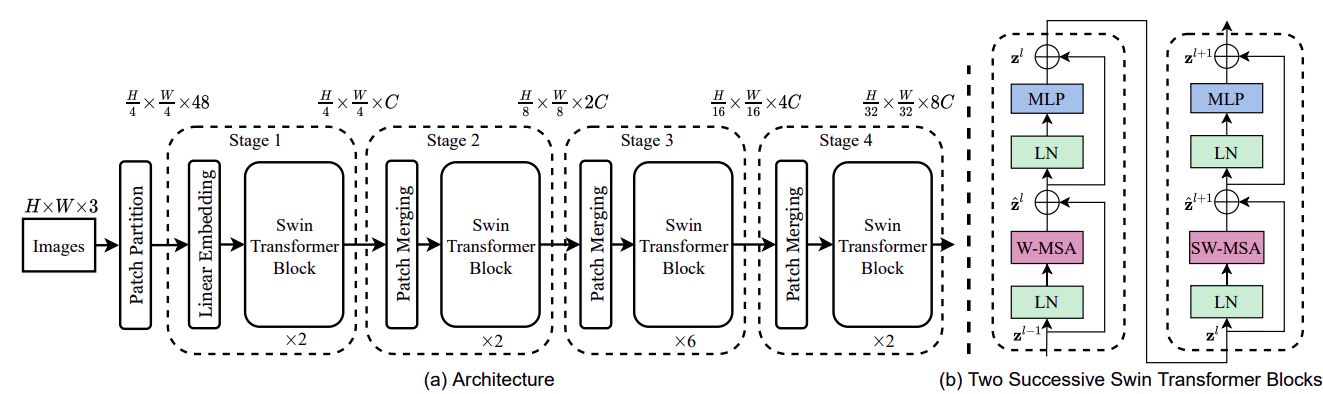



In [3]:
import torch
from torch import nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sample_input = torch.randn((1,3,224,224)).to(device)

### **Transformer Configs**

Reference repo:

* https://github.com/microsoft/Swin-Transformer/blob/main/models/swin_transformer.py

**Basic config for the SWIN transformer class**
    r""" Swin Transformer
        A PyTorch impl of : `Swin Transformer: Hierarchical Vision Transformer using Shifted Windows`  -
          https://arxiv.org/pdf/2103.14030

    Args:
        img_size (int | tuple(int)): Input image size. Default 224
        patch_size (int | tuple(int)): Patch size. Default: 4
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
        fused_window_process (bool, optional): If True, use one kernel to fused window shift & window partition for acceleration, similar for the reversed part. Default: False
    """

In [4]:
patch_size=(4,4)
embed_dim = 96
depths=[2, 2, 6, 2],
num_heads=[3, 6, 12, 24]
window_size=[7, 7]

# **Patch Partition Block**
As you can see the above SWIN transformer diagram you can see the patch partition block where it will convert the images into the patch of tokens using conv2d layer and aplly layer norm at last

In [6]:
class PatchPartition(nn.Module):
  def __init__(self, in_channels, patch_size, embed_dims, patch_norm_needed:bool = True):
    super().__init__()
    self.patch_size = patch_size
    self.embed_dim = embed_dim
    self.embedding = nn.Conv2d(in_channels=in_channels, out_channels=self.embed_dim,kernel_size=self.patch_size, stride=self.patch_size)
    self.patch_norm_needed = patch_norm_needed
    if self.patch_norm_needed:
      self.patch_norm = nn.LayerNorm(self.embed_dim)
  def forward(self, x: torch.Tensor):
    x=self.embedding(x)
    print(x.shape)
    x = x.permute(0,2,3,1)
    B,H,W,C = x.shape
    x = x.reshape(B,-1,C)
    if self.patch_norm_needed:
      x=self.patch_norm(x)
    return x
partition_layer=PatchPartition(in_channels=3, patch_size=patch_size,embed_dims=embed_dim).to(device)
layer_input=partition_layer(sample_input)
layer_input.shape

torch.Size([1, 96, 56, 56])


torch.Size([1, 3136, 96])

# **Patch Merging**

* To produce a hierarchical representation the number of tokens is reduced by patch merging layer on deeper.

* On the first patch merging layer,merge the 2*2 neighboring patches by concatinating into single patches of dimension `4C`. For an example, take a first `2 x 2` patches from `56 x 56` patches. When dimension (`C = 96`)is included, it results in `2 x 2 x 96` from `56 x 56 x 96`. Merge the `2 x 2 x 96` by `1 x 1 x 384`. i.e, take each patches `1 x 1 x 96` and concatenates over each one (`4C`). Now we get the feature map results for `56 x 56 x 96` where `14 x 14 x 384`. 

* Later linear trasnformation is applied where reduce the dimension from `4C` to `2C`. It results in the dimension from `384` to `192`. (**note:** we applied `nn.Linear` where it will get the input dimension of `4C` and output dimension sets to `2C`)

!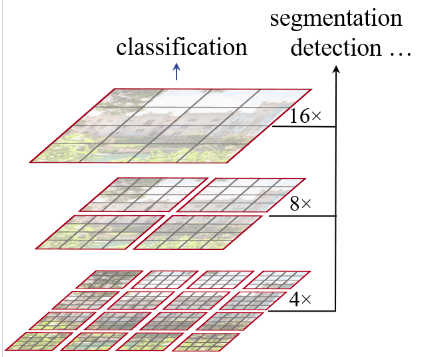

In [5]:
class PatchMerging(nn.Module):
    def __init__(self, dims, input_resolution):
        super().__init__()
        self.dims = dims
        self.input_resolution = input_resolution
        self.linear = nn.Linear(4 * self.dims, 2 * self.dims, bias=True)
        self.norm = nn.LayerNorm(4 * self.dims)


    def forward(self, x):
        B, T, C = x.shape
        H, W = self.input_resolution
        x = x.view(B, H, W, C)
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]        
        x3 = x[:, 1::2, 1::2, :]
        x = torch.cat([x0,x1,x2,x3],dim=3)
        x = self.norm(x)
        x=self.linear(x)
        x
        return x

patch_merging=PatchMerging(dims=96,input_resolution=(56,56)).to(device)
patch_merge_output=patch_merging(layer_input)
patch_merge_output.shape

torch.Size([1, 28, 28, 192])

# **Transformer Block**
* Swin transformer block consists of 3 components
    - Layer Normalisation
    - **W**indow - **M**ultihead **S**elf **A**ttention **(W-MSA)** & **S**hifted **W**indow - **M**ultihead **S**elf **A**ttention **(SW-MSA)**
    - Multi Layer Perceptron


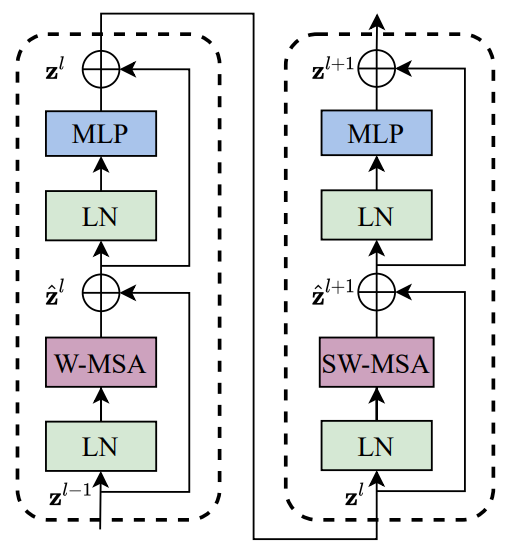

## **Window Self Attention**

* W-MSA will compute the attention score within the windows

* Where at first layer z<sup>l-1</sup>, partition the qkv matrix by given window size, In paper by default it window size is represented as 7 `(window_size=7)`

    - To partition it, reshape the qkv matrix `B x H x W x C` into `Nw_B x Wh X Ww X C`.

        - `Nw_B - Number of Windows x Batch size`
        - `Wh - Window height`
        - `Ww - Window Width`
        - `C - total number of channels`
    


In [6]:
def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


In [8]:
class WindowAttention(nn.Module):
    def __init__(self, dim, window_size, num_head, qkv_bias=True, qk_scale=None, attn_drop=0.0, proj_drop=0.0):
        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_head = num_head
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)

    def forward(self, x):
        B_, H, W, C = x.shape

        x = window_partition(x, window_size=self.window_size)
        x = x.view(-1, self.window_size * self.window_size, C)
        B_nW, T, C = x.shape

        qkv = self.qkv(x)
        qkv = qkv.reshape(B_nW, T, 3, self.num_head, -1).permute(
            2, 0, 3, 1, 4
        )  # since we applied linear trasnformation, we need to reshape the dimention and permute it
        q, k, v = qkv[0], qkv[1], qkv[2]

        print("Q shape:",q.shape)
        print("K shape:", k.shape)

        attn = q @ k.transpose(-2, -1)

        

        return attn


window_attention = WindowAttention(dim=192, window_size=7, num_head=6).to(device)
window_attention(patch_merge_output).shape

Q shape: torch.Size([16, 6, 49, 32])
K shape: torch.Size([16, 6, 49, 32])


torch.Size([16, 6, 49, 49])

In [16]:
window_size=(4,4)
num_heads = 1
print(window_size[0])
relative_position_bias =  torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads)
# relative_position_bias = torch.arange(1,50)[:, None]
relative_position_bias.shape

4


torch.Size([49, 1])

In [114]:
# get pair-wise relative position index for each token inside the window
coords_h = torch.arange(window_size[0])
coords_w = torch.arange(window_size[1])
coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
coords_flatten

tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
        [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]])

In [115]:
relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
relative_coords[0,:,:]

tensor([[ 0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2, -3, -3, -3, -3],
        [ 0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2, -3, -3, -3, -3],
        [ 0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2, -3, -3, -3, -3],
        [ 0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2, -3, -3, -3, -3],
        [ 1,  1,  1,  1,  0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2],
        [ 1,  1,  1,  1,  0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2],
        [ 1,  1,  1,  1,  0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2],
        [ 1,  1,  1,  1,  0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2],
        [ 2,  2,  2,  2,  1,  1,  1,  1,  0,  0,  0,  0, -1, -1, -1, -1],
        [ 2,  2,  2,  2,  1,  1,  1,  1,  0,  0,  0,  0, -1, -1, -1, -1],
        [ 2,  2,  2,  2,  1,  1,  1,  1,  0,  0,  0,  0, -1, -1, -1, -1],
        [ 2,  2,  2,  2,  1,  1,  1,  1,  0,  0,  0,  0, -1, -1, -1, -1],
        [ 3,  3,  3,  3,  2,  2,  2,  2,  1,  1,  1,  1,  0,  0,  0,  0],
        [ 3,  3,  3,  3,  2,  2,  2,  

In [116]:
relative_coords[1,:,:]

tensor([[ 0, -1, -2, -3,  0, -1, -2, -3,  0, -1, -2, -3,  0, -1, -2, -3],
        [ 1,  0, -1, -2,  1,  0, -1, -2,  1,  0, -1, -2,  1,  0, -1, -2],
        [ 2,  1,  0, -1,  2,  1,  0, -1,  2,  1,  0, -1,  2,  1,  0, -1],
        [ 3,  2,  1,  0,  3,  2,  1,  0,  3,  2,  1,  0,  3,  2,  1,  0],
        [ 0, -1, -2, -3,  0, -1, -2, -3,  0, -1, -2, -3,  0, -1, -2, -3],
        [ 1,  0, -1, -2,  1,  0, -1, -2,  1,  0, -1, -2,  1,  0, -1, -2],
        [ 2,  1,  0, -1,  2,  1,  0, -1,  2,  1,  0, -1,  2,  1,  0, -1],
        [ 3,  2,  1,  0,  3,  2,  1,  0,  3,  2,  1,  0,  3,  2,  1,  0],
        [ 0, -1, -2, -3,  0, -1, -2, -3,  0, -1, -2, -3,  0, -1, -2, -3],
        [ 1,  0, -1, -2,  1,  0, -1, -2,  1,  0, -1, -2,  1,  0, -1, -2],
        [ 2,  1,  0, -1,  2,  1,  0, -1,  2,  1,  0, -1,  2,  1,  0, -1],
        [ 3,  2,  1,  0,  3,  2,  1,  0,  3,  2,  1,  0,  3,  2,  1,  0],
        [ 0, -1, -2, -3,  0, -1, -2, -3,  0, -1, -2, -3,  0, -1, -2, -3],
        [ 1,  0, -1, -2,  1,  0, -1, -

In [117]:
relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
relative_coords[:, :, 0] += window_size[0] - 1  # shift to start from 0
relative_coords[:, :, 0]

# relative_coords[:, :, 0] *= 2 * window_size[1] - 1
# relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww


tensor([[3, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0],
        [3, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0],
        [3, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0],
        [3, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0],
        [4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1],
        [4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1],
        [4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1],
        [4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1],
        [5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2],
        [5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2],
        [5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2],
        [5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2],
        [6, 6, 6, 6, 5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 3],
        [6, 6, 6, 6, 5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 3],
        [6, 6, 6, 6, 5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 3],
        [6, 6, 6, 6, 5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 3]])

In [118]:
relative_coords[:, :, 1] += window_size[1] - 1
relative_coords[:, :, 1]

tensor([[3, 2, 1, 0, 3, 2, 1, 0, 3, 2, 1, 0, 3, 2, 1, 0],
        [4, 3, 2, 1, 4, 3, 2, 1, 4, 3, 2, 1, 4, 3, 2, 1],
        [5, 4, 3, 2, 5, 4, 3, 2, 5, 4, 3, 2, 5, 4, 3, 2],
        [6, 5, 4, 3, 6, 5, 4, 3, 6, 5, 4, 3, 6, 5, 4, 3],
        [3, 2, 1, 0, 3, 2, 1, 0, 3, 2, 1, 0, 3, 2, 1, 0],
        [4, 3, 2, 1, 4, 3, 2, 1, 4, 3, 2, 1, 4, 3, 2, 1],
        [5, 4, 3, 2, 5, 4, 3, 2, 5, 4, 3, 2, 5, 4, 3, 2],
        [6, 5, 4, 3, 6, 5, 4, 3, 6, 5, 4, 3, 6, 5, 4, 3],
        [3, 2, 1, 0, 3, 2, 1, 0, 3, 2, 1, 0, 3, 2, 1, 0],
        [4, 3, 2, 1, 4, 3, 2, 1, 4, 3, 2, 1, 4, 3, 2, 1],
        [5, 4, 3, 2, 5, 4, 3, 2, 5, 4, 3, 2, 5, 4, 3, 2],
        [6, 5, 4, 3, 6, 5, 4, 3, 6, 5, 4, 3, 6, 5, 4, 3],
        [3, 2, 1, 0, 3, 2, 1, 0, 3, 2, 1, 0, 3, 2, 1, 0],
        [4, 3, 2, 1, 4, 3, 2, 1, 4, 3, 2, 1, 4, 3, 2, 1],
        [5, 4, 3, 2, 5, 4, 3, 2, 5, 4, 3, 2, 5, 4, 3, 2],
        [6, 5, 4, 3, 6, 5, 4, 3, 6, 5, 4, 3, 6, 5, 4, 3]])

In [119]:
relative_coords[:, :, 0] *= 2 * window_size[1] - 1
relative_coords[:, :, 0]

tensor([[21, 21, 21, 21, 14, 14, 14, 14,  7,  7,  7,  7,  0,  0,  0,  0],
        [21, 21, 21, 21, 14, 14, 14, 14,  7,  7,  7,  7,  0,  0,  0,  0],
        [21, 21, 21, 21, 14, 14, 14, 14,  7,  7,  7,  7,  0,  0,  0,  0],
        [21, 21, 21, 21, 14, 14, 14, 14,  7,  7,  7,  7,  0,  0,  0,  0],
        [28, 28, 28, 28, 21, 21, 21, 21, 14, 14, 14, 14,  7,  7,  7,  7],
        [28, 28, 28, 28, 21, 21, 21, 21, 14, 14, 14, 14,  7,  7,  7,  7],
        [28, 28, 28, 28, 21, 21, 21, 21, 14, 14, 14, 14,  7,  7,  7,  7],
        [28, 28, 28, 28, 21, 21, 21, 21, 14, 14, 14, 14,  7,  7,  7,  7],
        [35, 35, 35, 35, 28, 28, 28, 28, 21, 21, 21, 21, 14, 14, 14, 14],
        [35, 35, 35, 35, 28, 28, 28, 28, 21, 21, 21, 21, 14, 14, 14, 14],
        [35, 35, 35, 35, 28, 28, 28, 28, 21, 21, 21, 21, 14, 14, 14, 14],
        [35, 35, 35, 35, 28, 28, 28, 28, 21, 21, 21, 21, 14, 14, 14, 14],
        [42, 42, 42, 42, 35, 35, 35, 35, 28, 28, 28, 28, 21, 21, 21, 21],
        [42, 42, 42, 42, 35, 35, 35, 3

In [10]:
relative_position_index = relative_coords.sum(-1)
relative_position_index

NameError: name 'relative_coords' is not defined

### Relative position bias

Ref Video: [Soroush Mehraban Video](https://www.youtube.com/watch?v=Ws2RAh_VDyU)

* In Vision Transformer paper, where images are divided into small patches to convert this as a token, given into the trasnformer it gives some output. Which shown in the below image


**Fig-1.1**

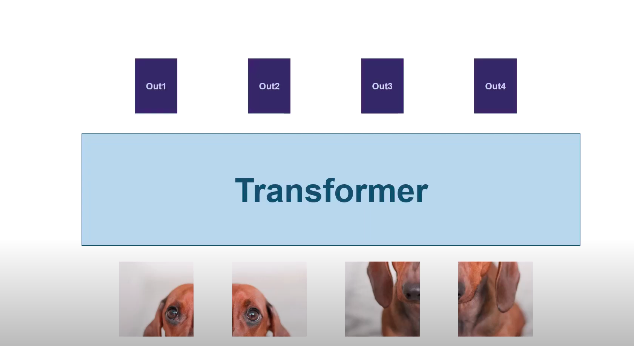

* If We change the order of the patches or the tokens, output tokenms will changes. On this cases both of the image input are same, when we merge the output it seems different. (See the below image)

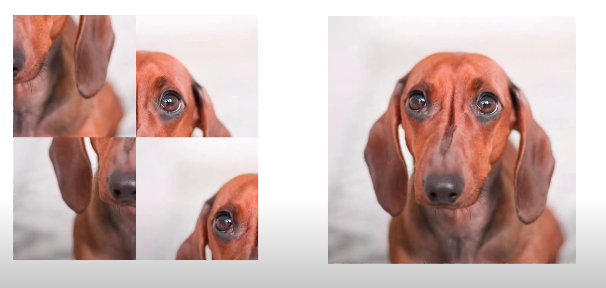

* To mitigate this problem, Absolute position Embedding was introduced in the original ViT paper.

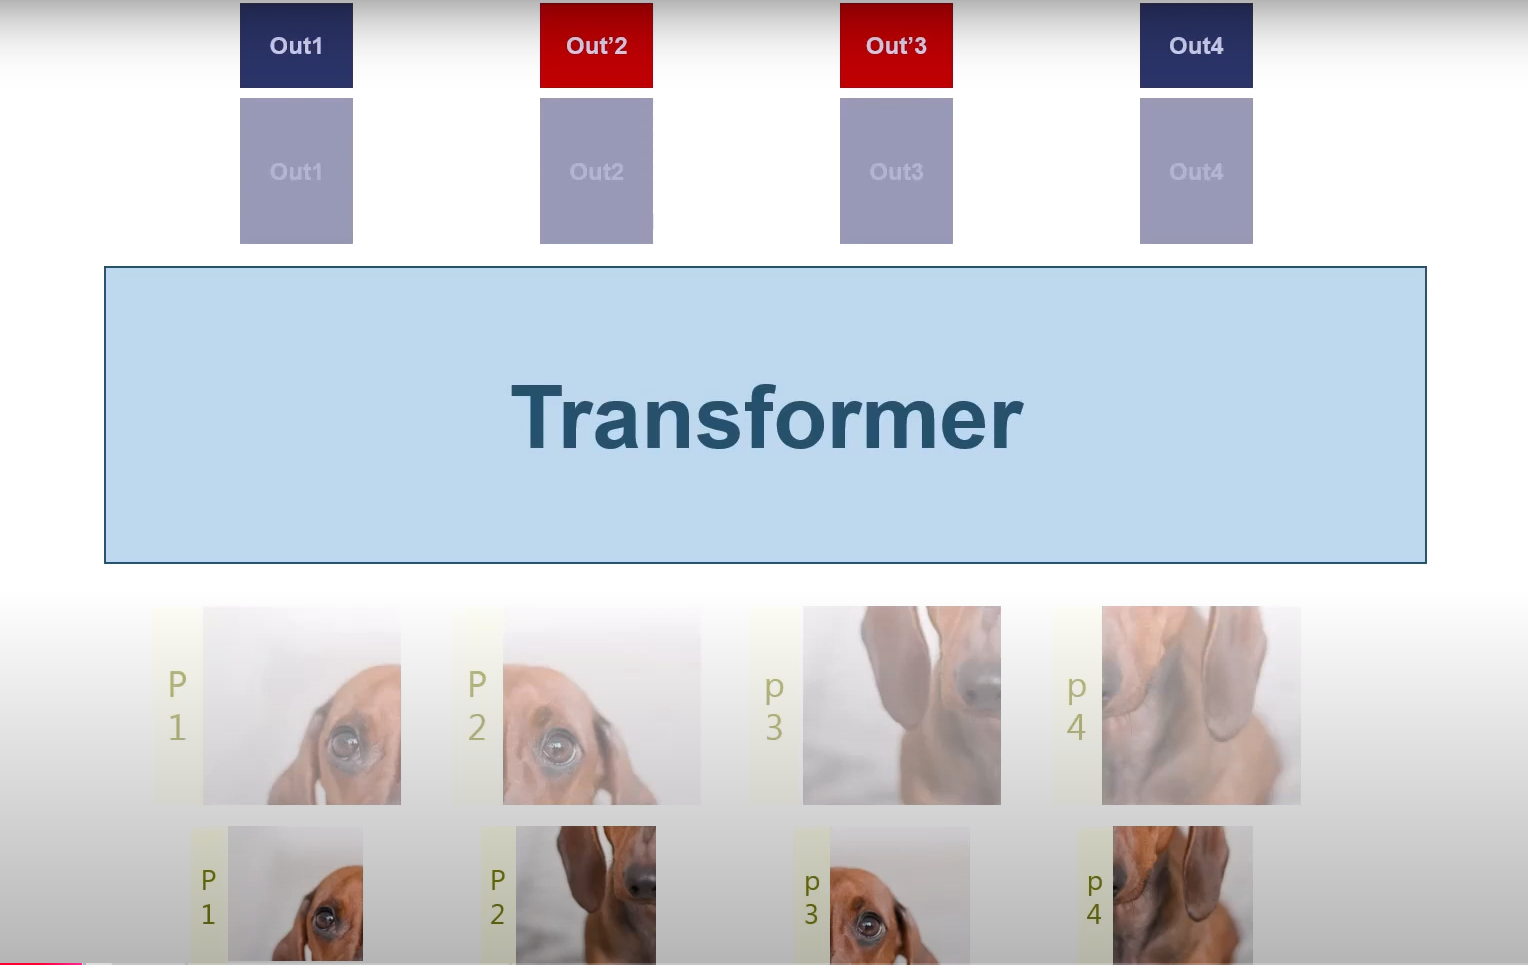

* Even after using this there is some limitaiton


* As of now consider a window size is `3 * 3` and number of heads which is equal to `1`

* We hava a input matrix `1 * 3 * 3 * 1`. But in realitme it will be multiples of 3 like `1 * 3W_h * 3W_w * C` where W_h  represents window height and W_w represents the window width

tensor([1, 0])

In [142]:
relative_position_bias[torch.Tensor([10,0]).to(int)]

tensor([[11],
        [ 1]])

In [2]:
import imgkit

imgkit.from_file('output_table.html', 'out.jpg')

QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True